In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
import scipy
import os
import random
import shutil

In [3]:
train_set = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/train"
test_set = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/test"
validation_set = "D:/Research/Oral Cancer Detection/Data/Mendeley Data/100x_Split_dataset_v2/validate"

In [4]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
validation_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_set,
    target_size = (224,224),
    batch_size = 32,
    shuffle=True,
    class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary')

Found 480 images belonging to 2 classes.
Found 149 images belonging to 2 classes.
Found 133 images belonging to 2 classes.


In [6]:
train_generator.class_indices

{'Normal': 0, 'OSCC': 1}

In [8]:
base_for_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=(224,224,3), include_top=False)

ImportError: `load_weights` requires h5py package when loading weights from HDF5. Try installing h5py.

In [7]:
for layer in base_for_model.layers:
    layer.trainable = False

In [8]:
model = Sequential()
model.add(base_for_model) 
model.add(GaussianNoise(0.25)) #to prevent overfitting
model.add(GlobalAveragePooling2D()) #to converge and reduce the parameters
model.add(Dense(512, activation = 'relu')) #hidden layer (relu activation function is suggested for images)
model.add(BatchNormalization()) #to prevent overfitting
model.add(Dense(1, activation='sigmoid')) #output layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 2048)       0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                        

In [9]:
adam= tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC']
)

In [10]:
mp= tf.keras.callbacks.ModelCheckpoint(filepath='resnet50.hdf5', 
                               verbose=2, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
callback=[es,mp]

In [11]:
history = model.fit(
    train_generator,
#   steps_per_epoch= 4946/32,
    epochs = 10, #own choice
    validation_data = validation_generator,
    callbacks=callback
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.6958 - precision: 0.9195 - recall: 0.6919 - auc: 0.7306
Epoch 1: val_loss improved from inf to 10.97264, saving model to resnet50.hdf5
15/15 [==============================] - 131s 7s/step - loss: 0.6524 - accuracy: 0.6958 - precision: 0.9195 - recall: 0.6919 - auc: 0.7306 - val_loss: 10.9726 - val_accuracy: 0.1678 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 0.4945 - accuracy: 0.7875 - precision: 0.9061 - recall: 0.8283 - auc: 0.7863
Epoch 2: val_loss improved from 10.97264 to 3.49254, saving model to resnet50.hdf5
15/15 [==============================] - 81s 6s/step - loss: 0.4945 - accuracy: 0.7875 - precision: 0.9061 - recall: 0.8283 - auc: 0.7863 - val_loss: 3.4925 - val_accuracy: 0.1678 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8111
Epoch 3/10
15/15 [==========================

In [19]:
print(history.history.keys())
acc=(history.history['accuracy'])
loss=(history.history['loss'])
prc=(history.history['precision'])
rec=(history.history['recall'])
auc=(history.history['auc'])
val_acc=(history.history['val_accuracy'])
val_loss=(history.history['val_loss'])
val_prc=(history.history['val_precision'])
val_rec=(history.history['val_recall'])
val_auc=(history.history['val_auc'])

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


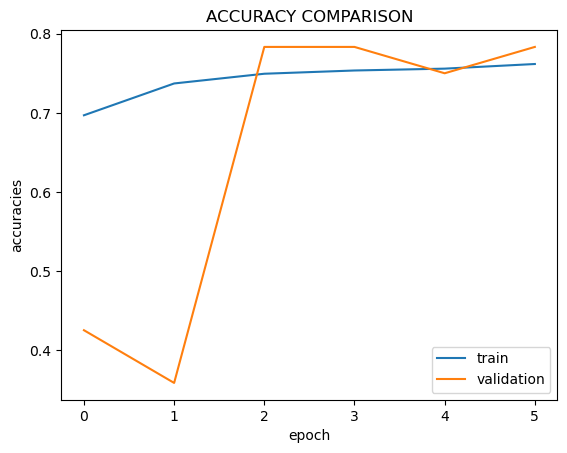

In [20]:
plt.plot(acc)
plt.plot(val_acc)
plt.title('ACCURACY COMPARISON')
plt.xlabel('epoch')
plt.ylabel('accuracies')
plt.title('ACCURACY COMPARISON')
plt.legend(['train','validation'])

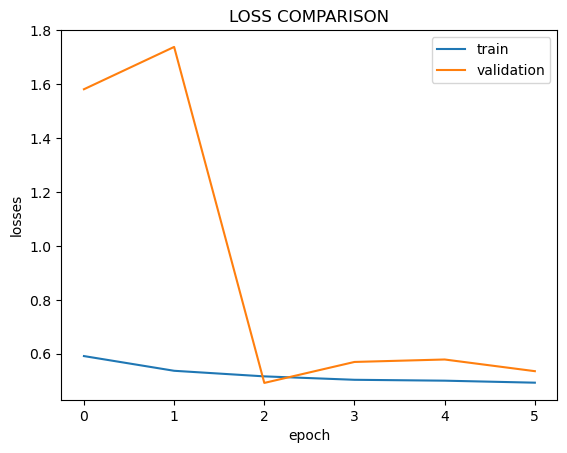

In [21]:
plt.title('LOSS COMPARISON')
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['train','validation'])

In [22]:
print("Model Train Evaluation")
model.evaluate(train_generator)
print("Model Validation Evaluation")
model.evaluate(validation_generator)
print("Model Test Evaluation")
model.evaluate(test_generator)

Model Train Evaluation
155/155 [==============================] - 195s 1s/step - loss: 0.5614 - accuracy: 0.7151 - precision: 0.6531 - recall: 0.9359 - auc: 0.8637
Model Validation Evaluation
4/4 [==============================] - 14s 4s/step - loss: 0.5234 - accuracy: 0.7750 - precision: 0.8037 - recall: 0.9348 - auc: 0.7510
Model Test Evaluation
4/4 [==============================] - 21s 6s/step - loss: 0.4990 - accuracy: 0.7698 - precision: 0.7895 - recall: 0.9474 - auc: 0.8166


[0.4989890456199646,
 0.7698412537574768,
 0.7894737124443054,
 0.9473684430122375,
 0.8166384100914001]

'Squamous Cell Carcinoma'

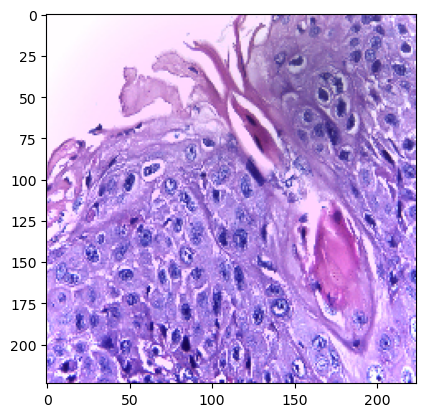

In [23]:
img =(image.load_img('D:/Research/Oral Cancer Detection/Data/Mendeley Data/Second Set/400x OSCC Histopathological Images/OSCC_400x_29.jpg',target_size=(224,224)))
imaga = image.img_to_array(img)
image = np.expand_dims(imaga,axis=0)  
ypred = model.predict(image)
if ypred<0.5:
      ypred="Normal"
else:
      ypred="Squamous Cell Carcinoma" 
plt.imshow(img)
ypred

<AxesSubplot: >

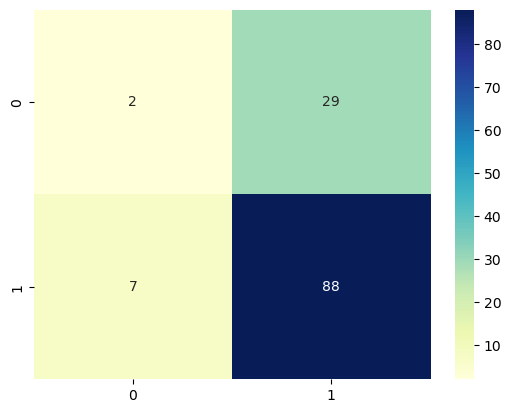

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_generator)
test_generator.classes
cm = confusion_matrix(test_generator.classes, predictions.round())

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

In [25]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predictions.round())) #.argmax(axis=-1)

              precision    recall  f1-score   support

           0       0.22      0.06      0.10        31
           1       0.75      0.93      0.83        95

    accuracy                           0.71       126
   macro avg       0.49      0.50      0.47       126
weighted avg       0.62      0.71      0.65       126



In [1]:
import joblib
joblib.dump(model, 'resnet50_model.joblib')

NameError: name 'model' is not defined